In [1]:
from google.colab import drive
drive.mount('/content/drive')
% cd drive/MyDrive/

Mounted at /content/drive
/content/drive/MyDrive


In [17]:
import pandas as pd
import numpy as np
from PIL import Image
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision.models as models
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pickle

In [6]:
epochs = 10
batch_size = 32
lr = 0.005
num_workers = 3
image_height, image_width = 64, 64

In [7]:
class CustomDataset(Dataset):
    def __init__(self, csv_path, image_folder, column_label):
        assert Path(csv_path).exists()
        assert Path(csv_path).is_file()
        
        assert Path(image_folder).exists() 
        assert Path(image_folder).is_dir()
        
        
        self.df = pd.read_csv(csv_path)
        self.image_folder = Path(image_folder)
        self.transform = T.Compose([
            T.ToTensor(),
            T.Resize((image_height, image_width)),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
        
        assert column_label in self.df.columns
        self.column_label = column_label
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        filename = self.df.loc[index]['Id'] + '.jpg'
        image_path = self.image_folder.joinpath(filename)
        image = self.transform(Image.open(image_path))
        
        label = self.df.loc[index][self.column_label]
        
        return image, label

In [8]:
pawpularity_dataset = CustomDataset('petfinder_data/train.csv', 'petfinder_data/train/', 'Pawpularity')
train_size = int(len(pawpularity_dataset) * 0.8)
test_size = len(pawpularity_dataset) - train_size
paw_train_data, paw_test_data = torch.utils.data.random_split(pawpularity_dataset, [train_size, test_size])

In [9]:
train_data = torch.utils.data.DataLoader(paw_train_data, shuffle=True, batch_size=batch_size, num_workers=num_workers)
test_data = torch.utils.data.DataLoader(paw_test_data, shuffle=True, batch_size=batch_size, num_workers=num_workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [10]:
# set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# import efficient net
efficient_net = models.efficientnet_b3(pretrained=True).to(device)

# don't update on model parameters
for param in efficient_net.parameters():
    param.requires_grad = False

# replace model classifier to fit our data
efficient_net.classifier[1] = nn.Sequential(nn.Sequential(
                    nn.Linear(1536, 256),
                    nn.ReLU(), 
                    nn.Dropout(0.2),
                    nn.Linear(256, 1)).to(device))

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-cf984f9c.pth


  0%|          | 0.00/47.2M [00:00<?, ?B/s]

In [11]:
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(efficient_net.classifier.parameters(), lr=lr)

In [12]:
avg_train_loss, avg_test_loss = [], []

for epoch in range(epochs):
    
    train_loss, test_loss = 0, 0 

    i = 0
    for inputs, labels in train_data:
        inputs = inputs.to(device)
        labels = labels.reshape(len(labels), 1).to(device)
        
        # zero out gradients
        optimizer.zero_grad()
        
        outputs = efficient_net(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss
        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            print('Epoch: {:<3d} \t Batch: {:>3d}/{:<3d}  \t Avg Train Loss: {:>3.2f}'.format(epoch, i, len(train_data), train_loss/(i+1)))
        i += 1

    v = 0
    for test_inputs, test_labels in test_data:
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.reshape(len(test_labels), 1).to(device)
        
        with torch.no_grad():
            test_out = efficient_net(test_inputs)
            tloss = criterion(test_out, test_labels)
            test_loss += tloss
            
        if v % 10 == 0:
            print('Epoch: {:<3d} \t Batch: {:>3d}/{:<3d} \t Avg Test Loss: {:>3.2f}'.format(epoch, v, len(test_data), test_loss/(v+1)))
        v += 1

    avg_train_loss.append(train_loss / len(train_data))
    avg_test_loss.append(test_loss / len(test_data))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 0   	 Batch:   0/248  	 Avg Train Loss: 28.31
Epoch: 0   	 Batch:  10/248  	 Avg Train Loss: 26.61
Epoch: 0   	 Batch:  20/248  	 Avg Train Loss: 25.35
Epoch: 0   	 Batch:  30/248  	 Avg Train Loss: 24.25
Epoch: 0   	 Batch:  40/248  	 Avg Train Loss: 24.10
Epoch: 0   	 Batch:  50/248  	 Avg Train Loss: 23.65
Epoch: 0   	 Batch:  60/248  	 Avg Train Loss: 23.30
Epoch: 0   	 Batch:  70/248  	 Avg Train Loss: 23.05
Epoch: 0   	 Batch:  80/248  	 Avg Train Loss: 22.68
Epoch: 0   	 Batch:  90/248  	 Avg Train Loss: 22.57
Epoch: 0   	 Batch: 100/248  	 Avg Train Loss: 22.06
Epoch: 0   	 Batch: 110/248  	 Avg Train Loss: 21.78
Epoch: 0   	 Batch: 120/248  	 Avg Train Loss: 21.50
Epoch: 0   	 Batch: 130/248  	 Avg Train Loss: 21.32
Epoch: 0   	 Batch: 140/248  	 Avg Train Loss: 21.06
Epoch: 0   	 Batch: 150/248  	 Avg Train Loss: 20.88
Epoch: 0   	 Batch: 160/248  	 Avg Train Loss: 20.64
Epoch: 0   	 Batch: 170/248  	 Avg Train Loss: 20.52
Epoch: 0   	 Batch: 180/248  	 Avg Train Loss:

In [13]:
avg_test_loss

[tensor(17.2793, device='cuda:0'),
 tensor(16.4759, device='cuda:0'),
 tensor(16.4965, device='cuda:0'),
 tensor(16.6577, device='cuda:0'),
 tensor(16.2983, device='cuda:0'),
 tensor(16.0386, device='cuda:0'),
 tensor(16.0859, device='cuda:0'),
 tensor(16.1571, device='cuda:0'),
 tensor(16.1047, device='cuda:0'),
 tensor(15.9391, device='cuda:0')]

In [14]:
avg_train_loss

[tensor(19.4818, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(17.2330, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(16.3887, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(16.2743, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(16.0690, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(16.1146, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(15.8608, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(15.8354, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(15.7790, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(15.5984, device='cuda:0', grad_fn=<DivBackward0>)]

In [15]:
torch.stack(avg_train_loss).cpu().detach().numpy()

array([19.481834, 17.232994, 16.388685, 16.27425 , 16.06902 , 16.114555,
       15.860844, 15.835362, 15.778984, 15.598387], dtype=float32)

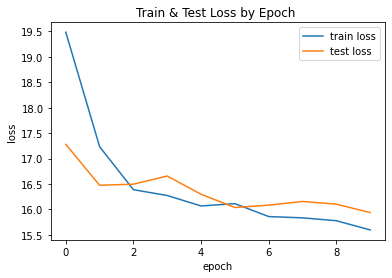

In [16]:
ep = np.arange(epochs)

plt.plot(ep, torch.stack(avg_train_loss).cpu().detach().numpy(), label='train loss')
plt.plot(ep, torch.stack(avg_test_loss).cpu().detach().numpy(), label='test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Train & Test Loss by Epoch ')
plt.legend()

In [23]:
path = '/content/drive/MyDrive/Colab Notebooks/'
pickle.dump(efficient_net, open(path + 'eff_net.sav', 'wb'))